In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_dataset
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
alphabet = ['A', 'T', 'G', 'C']
classes = ['psychrophilic', 'mesophilic', 'thermophilic']

In [4]:
run_id = 'run_94oi0'
model_path = os.path.join(os.getcwd(), f'saved_models_regression/{run_id}/model.h5')
hyperparameters_path = os.path.join(os.getcwd(), f'saved_models_regression/{run_id}/metadata.json')
test_set_path = os.path.join(os.getcwd(), 'data/dataset_test.csv')

In [5]:
with open(hyperparameters_path) as f:
    metadata = json.load(f)
    
metadata

{'run_id': 'run_94oi0',
 'alphabet': ['A', 'T', 'G', 'C'],
 'classes': ['psychrophilic', 'mesophilic', 'thermophilic'],
 'model_type': 'conv1d_densenet',
 'n_epochs': 197,
 'growth_rate': 19,
 'n_layers': 5,
 'kernel_sizes': [2, 3, 10, 20, 30],
 'l2_reg': 0.0001,
 'dropout': 0.5,
 'seed': 4556,
 'val_loss': 1.202218529340383,
 'val_mae': 15.57646369934082}

In [6]:
model = conv1d_densenet_regression_model(
    alphabet_size=len(alphabet), 
    growth_rate=metadata['growth_rate'],
    n_layers=metadata['n_layers'],
    kernel_sizes=metadata['kernel_sizes'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
compile_regression_model(model, learning_rate=1e-4)
model.load_weights(model_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 19)     171         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 23)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 19)     1330        concat_1[0][0]               

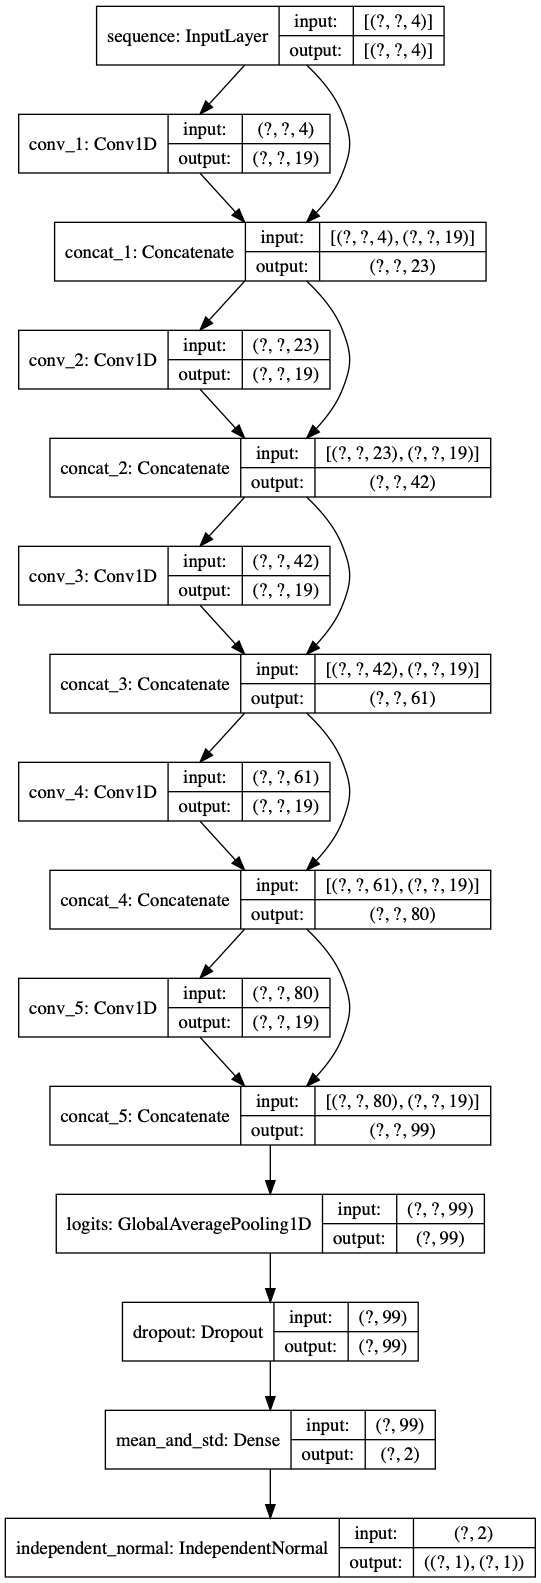

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
dataset_df = load_dataset(test_set_path, alphabet, secondary=False)
dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content,ag_content,gt_content
0,Micropolyspora internatus,NC_013159.1,rnpB,742238,742645,407,+,45.0,thermophilic,CGAGTTGGCAGGGCGGCCGCGGCCGAGGGCATCGTCTCGACGTCTT...,0.685504,0.562654,0.508600
1,Listonella anguillarum,NC_015633.1,recA,2753532,2754579,1047,-,20.0,psychrophilic,ATGGACGAAAATAAGCAGAAGGCGCTAGCCGCAGCACTGGGTCAAA...,0.442216,0.540592,0.510029
2,Comamonas badia,NZ_AXVM01000006.1,rpsR,29593,29878,285,-,28.0,mesophilic,TTGACCATGTTCAGGAAATTCAACAAGAATGGCAAGAACGGCAAGC...,0.568421,0.494737,0.414035
3,Acetobacter orientalis,NZ_BAMX01000009.1,tsaD,11584,12799,1215,-,30.0,mesophilic,ATGGCGGTCAGCAGCCAGTTTTCAGGCTTACCCGGCACCCCTCACA...,0.596708,0.469959,0.476543
4,Alicyclobacillus kakegawensis,NZ_BCRP01000001.1,tsaD,64880,65918,1038,-,50.0,thermophilic,TTGCTCCTGTTGGGCATTGAGACGAGTTGCGACGAGACCGCCGCGG...,0.680154,0.516378,0.564547


In [9]:
dataset_df.shape

(3700, 13)

In [10]:
y = dataset_df['temperature'].values.astype(np.float64)
sequences = dataset_df['sequence'].values
x = sequence_embedding(sequences, alphabet)

In [11]:
mean, std = np.mean(y), np.std(y)
y_norm = normalize(y, mean, std)

## Evaluate model

In [12]:
%%time
model.evaluate(x, y_norm, verbose=0)

CPU times: user 1min 42s, sys: 1.83 s, total: 1min 44s
Wall time: 15.9 s


1.2118407927332697

In [13]:
%%time
y_hat = model(x)

CPU times: user 1min 58s, sys: 41.5 s, total: 2min 40s
Wall time: 34.7 s


In [14]:
y_mean = denormalize(y_hat.mean().numpy(), mean, std)
y_std = denormalize(y_hat.stddev().numpy(), mean, std)
y_mean.shape

(3700, 1)

In [15]:
mae = np.mean(np.abs(y_mean - y))
rmse = np.sqrt(np.mean((y_mean - y) **2))
print(f'Mean Absolute Error   : {mae:.2f}')
print(f'Root Mean Square Error: {rmse:.2f}')

Mean Absolute Error   : 15.96
Root Mean Square Error: 20.39


In [16]:
y_baseline = np.array([np.mean(y)] * len(y))
mae_baseline = np.mean(np.abs(y_baseline - y))
rmse_baseline = np.sqrt(np.mean((y_baseline - y) ** 2))
print(f'Baseline Mean Absolute Error   : {mae_baseline:.2f}')
print(f'Baseline Root Mean Square Error: {rmse_baseline:.2f}')

Baseline Mean Absolute Error   : 14.09
Baseline Root Mean Square Error: 16.77


In [17]:
def plot_true_vs_prediction_scatter(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    predictions_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        predictions_per_temp[y_t].append(y_p)
        
        label = None
        if i == 0:
            label = 'Actual'
        
        ax.plot(y_t, y_p, 'o', color=palette[0], alpha=0.1, label=label)
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p_mean = np.mean(predictions_per_temp[y_t])
        
        label = None
        if i == 0:
            label = 'Average'
            
        ax.plot(y_t, y_p_mean, 'o', color=palette[1], label=label)
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    ax.legend()
    return f, ax

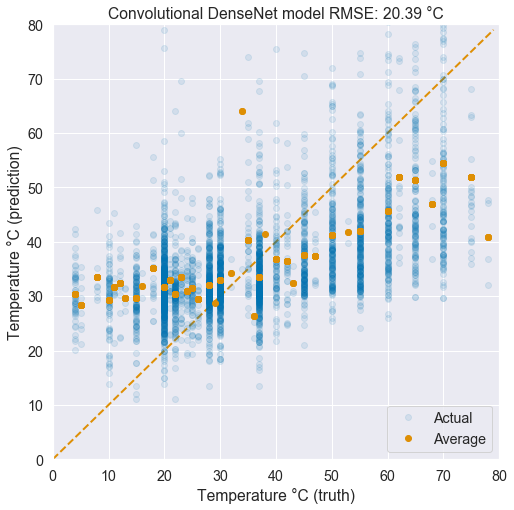

In [18]:
_, ax = plot_true_vs_prediction_scatter(y, y_mean)
ax.set_title(f'Convolutional DenseNet model RMSE: {rmse:.2f} °C');

In [19]:
def plot_mae_per_temperature(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    error_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        err = np.abs(y_t - y_p)
        error_per_temp[y_t].append(err)
        
        label = None
        if i == 0:
            label = 'Actual'
        
        ax.plot(y_t, err, 'o', color=palette[0], alpha=0.1, label=label)
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_err_mean = np.mean(error_per_temp[y_t])
        
        label = None
        if i == 0:
            label = 'Average'
        
        ax.plot(y_t, y_err_mean, 'o', color=palette[1], label=label)
        
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Absolute error (°C)')
    ax.legend()
    
    return f, ax

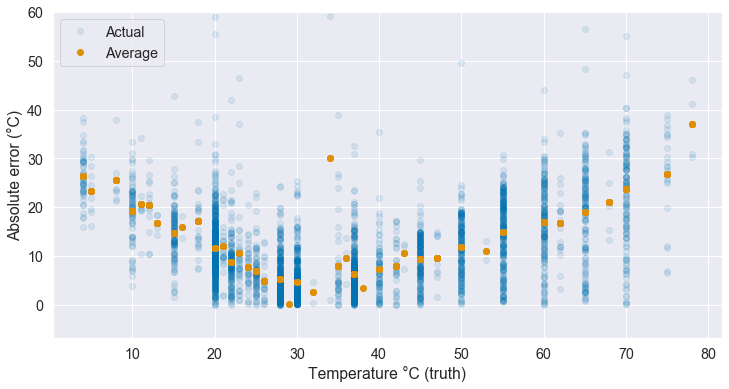

In [20]:
f, ax = plot_mae_per_temperature(y, y_mean)
ax.set_ylim(None, 60);

In [21]:
def plot_std_per_temperature(y_true, y_std):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    std_per_temp = collections.defaultdict(list)
    for i in range(len(y_true)):
        y_t = y_true[i]
        std_per_temp[y_t].append(y_std[i])
        
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_std_mean = np.mean(std_per_temp[y_t])
        
        ax.plot(y_t, y_std_mean, 'o', color=palette[0])
        
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Average standard deviation (°C)')
    
    return f, ax

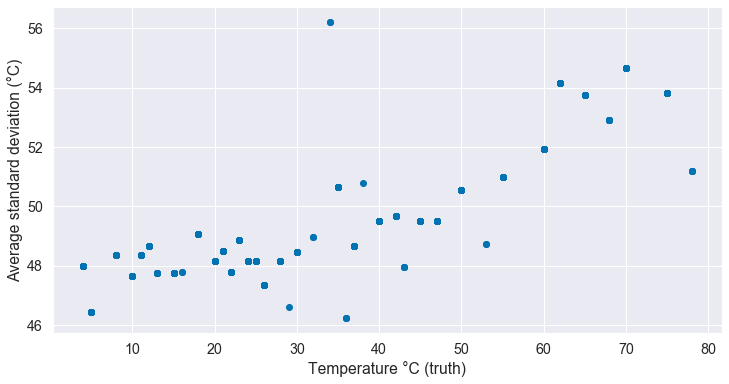

In [22]:
plot_std_per_temperature(y, y_std);

In [23]:
def mae_per_gene(dataset_df, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(6, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        df = dataset_df[dataset_df['gene_name'] == gene]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    sorted_idx = np.argsort([np.sum(r) for r in results]).tolist()
    
    cm = pd.DataFrame(
        np.array(results)[sorted_idx], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx])],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Mean average error (°C)')
    
    return f, ax, genes[sorted_idx]

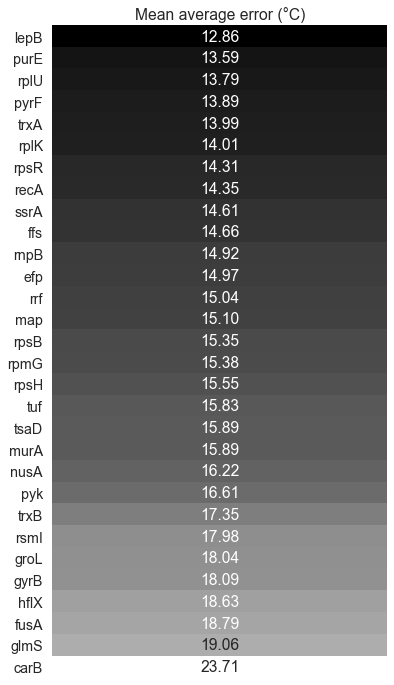

In [24]:
_, _, sorted_genes = mae_per_gene(dataset_df, y, y_mean)

In [25]:
def mae_per_temperature_band(dataset_df, y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(6, 10))
    palette = sns.color_palette()
    
    bucket_size = 5
    bucket_starts = list(range(2, 76, bucket_size))
    temp_buckets = [f'{s}-{s + (bucket_size - 1)} °C' for s in bucket_starts]
    
    results = []
    for i, bucket_start in enumerate(bucket_starts):
        df = dataset_df[
            (dataset_df['temperature'] >= bucket_start) &
            (dataset_df['temperature'] < bucket_start + bucket_size)
        ]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    cm = pd.DataFrame(
        np.array(results), 
        index=[f'{g}' for i, g in enumerate(temp_buckets)],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax, linewidths=1, linecolor='#cccccc');
    plt.yticks(rotation=0)
    ax.set_title('MAE per temperature band')

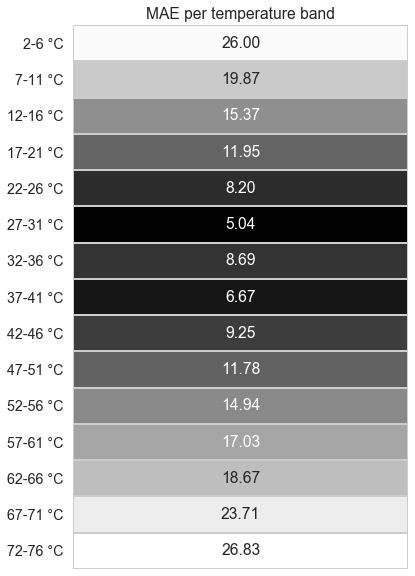

In [26]:
mae_per_temperature_band(dataset_df, y, y_mean)

## Per species

In [27]:
species_dataset = os.path.join(os.getcwd(), 'data/dataset_balanced_test.csv')
species_dataset_df = load_dataset(species_dataset, alphabet, secondary=False)
species_dataset_df.head()

,specie_name,seqid,gene_name,start_inclusive,end_exclusive,length,strand,temperature,temperature_range,sequence,gc_content,ag_content,gt_content
0,Acetobacter pasteurianus,NC_013209.1,recA,43040,44075,1035,+,26.0,mesophilic,ATGGTAAAAATGGATAAGGCAAAGGCTCTCGAAGGCGCGCTGGGGC...,0.526570,0.549758,0.543961
1,Acetobacter pasteurianus,NC_013209.1,ffs,51809,51907,98,+,26.0,mesophilic,GGAAAGTCGGCAGTGGACGGATACCTTGCCAACCCGGTCAGATCCG...,0.571429,0.520408,0.520408
2,Acetobacter pasteurianus,NC_013209.1,map,288964,289765,801,-,26.0,mesophilic,ATGGCCGGCAGAGGCGGAATTATTCTGCATACTGAAGAAGATTTTA...,0.516854,0.503121,0.506866
3,Acetobacter pasteurianus,NC_013209.1,murA,402403,403666,1263,-,26.0,mesophilic,ATGGATCGTTTCATCATCCGGGGCGGACGCCCCCTGCACGGCGAAA...,0.588282,0.501188,0.510689
4,Acetobacter pasteurianus,NC_013209.1,pyk,638524,639985,1461,+,26.0,mesophilic,ATGGCTGAATCCACACAACAGGGTTCGGGCGCAGAACAGGCGCAAA...,0.607118,0.517454,0.531143


In [28]:
def predictions_per_specie(species_dataset_df, model, mean, std, alphabet, selected_genes=None):
    species = sorted(species_dataset_df['specie_name'].unique().tolist())
    
    predictions, actuals = [], []
    for i, specie in enumerate(species):
        print(f'{i + 1} / {len(species)}: {specie}')
        
        if selected_genes is not None:
            df = species_dataset_df[
                (species_dataset_df['specie_name'] == specie) &
                (species_dataset_df['gene_name'].isin(selected_genes))
            ]
        else:
            df = species_dataset_df[species_dataset_df['specie_name'] == specie]
            
        y_s = df['temperature'].values.astype(np.float64)[0]
        sequences_s = df['sequence'].values
        x_s = sequence_embedding(sequences_s, alphabet)
    
        y_s_hat = model(x_s)
        y_s_mean = denormalize(y_s_hat.mean().numpy(), mean, std)
        
        y_pred = np.mean(y_s_mean)

        predictions.append(y_pred)
        actuals.append(y_s)
    
    return np.array(species), np.array(predictions), np.array(actuals)

In [29]:
species, predictions, actuals = predictions_per_specie(species_dataset_df, model, mean, std, alphabet)

1 / 238: Acetobacter nitrogenifigens
2 / 238: Acetobacter pasteurianus
3 / 238: Acidaminococcus intestini
4 / 238: Acidiplasma cupricumulans
5 / 238: Acidithiobacillus caldus
6 / 238: Acidovorax avenae
7 / 238: Acidovorax citrulli
8 / 238: Acidovorax soli
9 / 238: Acinetobacter seifertii
10 / 238: Actinocatenispora sera
11 / 238: Adhaeribacter aquaticus
12 / 238: Aeromonas bestiarum
13 / 238: Agathobacter rectalis
14 / 238: Algoriphagus aquimarinus
15 / 238: Algoriphagus ratkowskyi
16 / 238: Alicyclobacillus acidocaldarius
17 / 238: Alicyclobacillus acidoterrestris
18 / 238: Alicyclobacillus herbarius
19 / 238: Aliivibrio salmonicida
20 / 238: Alkaliphilus peptidifermentans
21 / 238: Allobaculum stercoricanis
22 / 238: Alloscardovia criceti
23 / 238: Alteromonas stellipolaris
24 / 238: Anaerobacillus alkalidiazotrophicus
25 / 238: Anaerolinea thermolimosa
26 / 238: Aquisalimonas asiatica
27 / 238: Arcanobacterium haemolyticum
28 / 238: Archangium gephyra
29 / 238: Ardenticatena maritim

In [30]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [31]:
mae_species = np.mean(np.abs(predictions - actuals))
rmse_species = np.sqrt(np.mean((predictions - actuals) **2))

print(f'MAE species : {mae_species:.2f}')
print(f'RMSE species: {rmse_species:.2f}')
print(f'Correlation : {np.corrcoef(actuals, predictions)[0, 1]:.2f}')

MAE species : 9.83
RMSE species: 16.38
Correlation : 0.46


In [32]:
predictions_35 = np.array([35.] * len(actuals))
mae_species_35 = np.mean(np.abs(predictions_35 - actuals))
rmse_species_35 = np.sqrt(np.mean((predictions_35 - actuals) **2))

print(f'MAE 35 °C : {mae_species_35:.2f}')
print(f'RMSE 35 °C: {rmse_species_35:.2f}')

MAE 35 °C : 10.24
RMSE 35 °C: 13.18


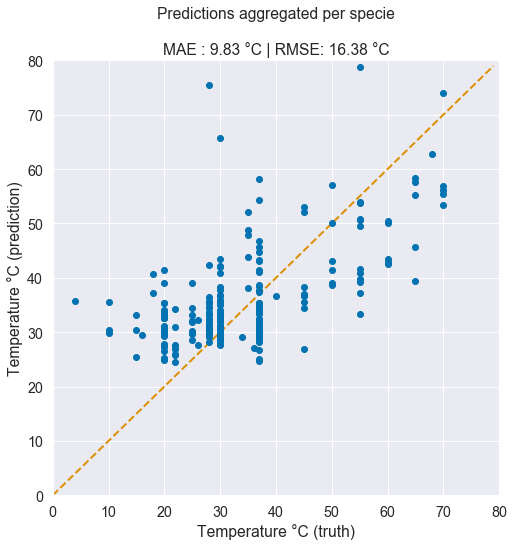

In [33]:
f, ax = plot_true_vs_prediction_per_specie(actuals, predictions)
title = f'Predictions aggregated per specie\n\n'
title += f'MAE : {mae_species:.2f} °C | '
title += f'RMSE: {rmse_species:.2f} °C'
ax.set_title(title);